In [72]:
import glob
base_path = './xray_classification_pneumonia/Dataset_compressed/train'
file_path = list(glob.glob(base_path + "/*/*.*"))
pneumonia = list(glob.glob(base_path+"/PNEUMONIA/*.*"))
normal = list(glob.glob(base_path+"/NORMAL/*.*"))

In [73]:
len(pneumonia), len(normal)

(3875, 1341)

In [74]:
import matplotlib.pyplot as plt
import os
test = os.path.dirname(file_path[0])
print(test)
class_name = os.path.split(os.path.dirname(test))
print(class_name)

./xray_classification_pneumonia/Dataset_compressed/train\NORMAL
('./xray_classification_pneumonia/Dataset_compressed', 'train')


In [75]:
# folder name to label
labels = []
for fp in file_path:
    tmp = os.path.dirname(fp)
    class_name = os.path.split(tmp)
    if class_name[1] == "PNEUMONIA":
        labels.append(1)
    else:
        labels.append(0)
        
import numpy as np
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2

img_width = 60 # size 고정
img_height = 60

dataset = np.ndarray(shape=(len(file_path), img_height*img_width), dtype=np.float32)  # array로 바꿈
i=0
for _file in file_path:
    img = cv2.imread(_file, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_width, img_height))
    
    dataset[i] = img_resized.flatten()
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


In [76]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [77]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

In [78]:
len(X_train),len(X_test), len(y_train), len(y_test)

(4172, 1044, 4172, 1044)

In [79]:
y_train, y_test =  map(lambda x: to_categorical(x), [y_train, y_test])

### 모델 생성

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

In [81]:
def build():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(3600,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return model

model = build()
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 100)               360100    
                                                                 
 dense_40 (Dense)            (None, 50)                5050      
                                                                 
 dense_41 (Dense)            (None, 2)                 102       
                                                                 
Total params: 365,252
Trainable params: 365,252
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.predict(dataset)

163/163 [==============================] - 0s 1ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Adam 학습

In [83]:
model_adam = build()
model_adam.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history= model_adam.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=20
)

Epoch 1/20
66/66 [==============================] - 1s 6ms/step - loss: 37.7399 - accuracy: 0.7735 - val_loss: 0.9663 - val_accuracy: 0.9138
Epoch 2/20
66/66 [==============================] - 0s 4ms/step - loss: 1.7069 - accuracy: 0.8811 - val_loss: 0.6854 - val_accuracy: 0.9310
Epoch 3/20
66/66 [==============================] - 0s 4ms/step - loss: 1.0504 - accuracy: 0.8998 - val_loss: 7.9825 - val_accuracy: 0.7395
Epoch 4/20
66/66 [==============================] - 0s 4ms/step - loss: 1.5183 - accuracy: 0.9027 - val_loss: 0.9067 - val_accuracy: 0.9282
Epoch 5/20
66/66 [==============================] - 0s 4ms/step - loss: 1.0070 - accuracy: 0.9128 - val_loss: 0.5351 - val_accuracy: 0.9569
Epoch 6/20
66/66 [==============================] - 0s 4ms/step - loss: 0.4282 - accuracy: 0.9516 - val_loss: 0.5580 - val_accuracy: 0.9435
Epoch 7/20
66/66 [==============================] - 0s 4ms/step - loss: 1.2096 - accuracy: 0.9106 - val_loss: 1.2434 - val_accuracy: 0.8975
Epoch 8/20
66/66 [=

### 예측

In [84]:
import matplotlib.pyplot as plt
import numpy as np

predictions = model_adam.predict(X_test)
predicted_class = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

33/33 [==============================] - 0s 1ms/step


### 정확도 계산

In [85]:
accuracy = np.mean(predicted_class == true_classes)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 92.43%


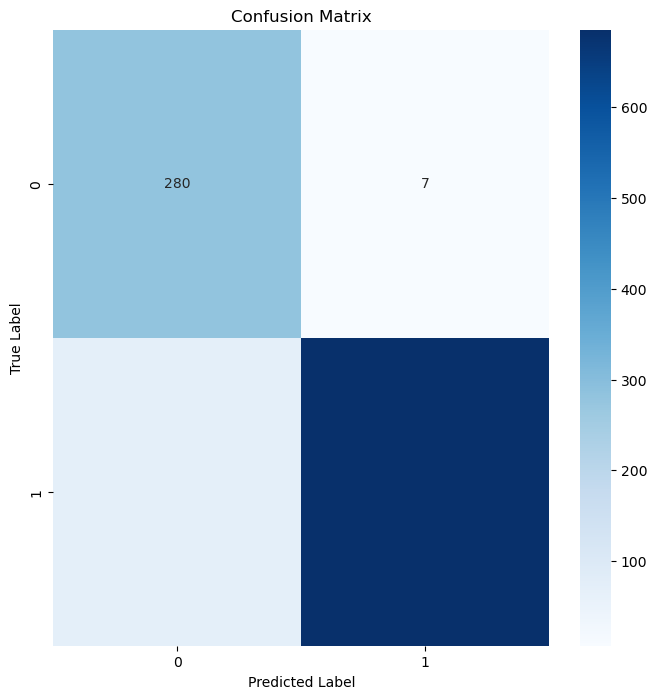

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_classes, predicted_class)
plt.figure(figsize=(8,8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

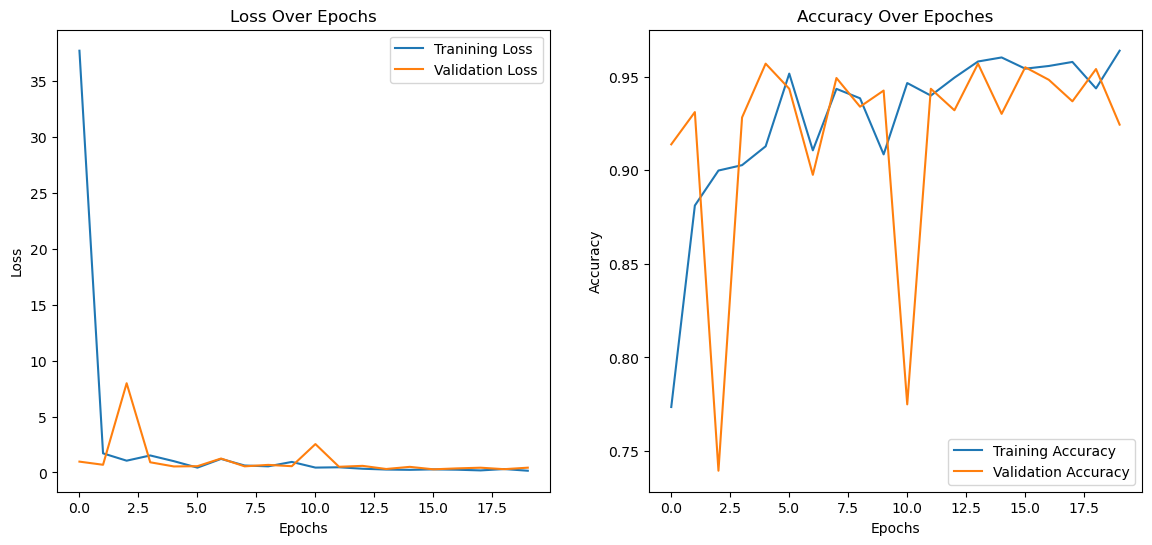

In [87]:
# Train, Val 시각화 - loss
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Tranining Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epoches')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### CNN

In [88]:
import glob
base_path = './xray_classification_pneumonia/Dataset_compressed/train'
file_path = list(glob.glob(base_path + "/*/*.*"))
pneumonia = list(glob.glob(base_path+"/PNEUMONIA/*.*"))
normal = list(glob.glob(base_path+"/NORMAL/*.*"))

In [117]:
label_name = {
    0: 'Normal',
    1: "Pneumonia"
}

In [89]:
len(pneumonia), len(normal)

(3875, 1341)

In [90]:
import matplotlib.pyplot as plt
import os
test = os.path.dirname(file_path[0])
print(test)
class_name = os.path.split(os.path.dirname(test))
print(class_name)

./xray_classification_pneumonia/Dataset_compressed/train\NORMAL
('./xray_classification_pneumonia/Dataset_compressed', 'train')


In [91]:
# folder name to label
labels = []
for fp in file_path:
    tmp = os.path.dirname(fp)
    class_name = os.path.split(tmp)
    if class_name[1] == "PNEUMONIA":
        labels.append(1)
    else:
        labels.append(0)

In [92]:
import numpy as np
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2

img_width = 60 # size 고정
img_height = 60

dataset = np.ndarray(shape=(len(file_path), img_height*img_width), dtype=np.float32)  # array로 바꿈
i=0
for _file in file_path:
    img = cv2.imread(_file, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_width, img_height))
    
    dataset[i] = img_resized.flatten()
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


In [93]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

image_width = 60
image_height = 60

channels = 3

dataset = np.ndarray(shape=(len(file_path), image_height, image_width, channels),dtype=np.float32)


i=0
for _file in file_path:
    img = load_img(_file)
    img.thumbnail((image_width, image_height))
    x = img_to_array(img)
    dataset[i] = x
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


### 데이터 시각화

In [94]:
import cv2
im0 = cv2.imread(pneumonia[67])
im1 = cv2.imread(normal[67])

im0.shape, im1.shape

((60, 60, 3), (60, 60, 3))

(-0.5, 59.5, 59.5, -0.5)

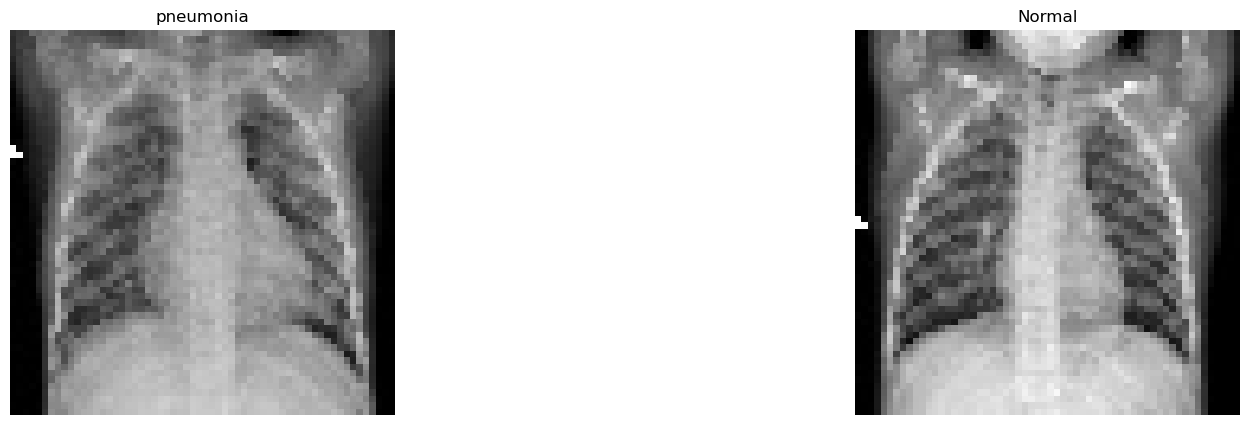

In [95]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('pneumonia')
plt.imshow(im0)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Normal')
plt.imshow(im1)
plt.axis('off')

In [96]:
# train, val, test dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=321)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
y_train, y_test, y_val =  to_categorical(y_train), to_categorical(y_test), to_categorical(y_val)

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_val = x_val.astype('float32')/255.

In [97]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((4172, 60, 60, 3),
 (4172, 2),
 (522, 60, 60, 3),
 (522, 2),
 (522, 60, 60, 3),
 (522, 2))

### CNN 생성

In [98]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers 

In [99]:
# Valilla CNN
def build():
    CNN = Sequential()
    
    # 합성곱1층
    CNN.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(60,60,3)))
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    CNN.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    CNN.add(Flatten())
    CNN.add(Dense(1000, activation='relu'))
    CNN.add(Dense(500, activation='relu'))
    CNN.add(Dense(2, activation='softmax')) # 확률 반환 - 0일 확률 또는 1일 확률
    
    return CNN

In [100]:
# metric function
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (possible_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [101]:
BATCH_SIZE = 32

### 학습

In [102]:
CNN_Adam = build()

opt = optimizers.Adam(learning_rate=0.001)

CNN_Adam.compile(
    optimizer = opt, 
    loss='categorical_crossentropy', 
    metrics = ['accuracy',
                recall_m, 
                precision_m,
                f1_m]  
)

In [103]:
epochs = 20
history = CNN_Adam.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = BATCH_SIZE
)

Epoch 1/20
131/131 [==============================] - 21s 157ms/step - loss: 0.2522 - accuracy: 0.9017 - recall_m: 0.9018 - precision_m: 0.9018 - f1_m: 0.9018 - val_loss: 0.1755 - val_accuracy: 0.9406 - val_recall_m: 0.9430 - val_precision_m: 0.9430 - val_f1_m: 0.9430
Epoch 2/20
131/131 [==============================] - 19s 144ms/step - loss: 0.1082 - accuracy: 0.9597 - recall_m: 0.9595 - precision_m: 0.9595 - f1_m: 0.9595 - val_loss: 0.1152 - val_accuracy: 0.9540 - val_recall_m: 0.9559 - val_precision_m: 0.9559 - val_f1_m: 0.9559
Epoch 3/20
131/131 [==============================] - 20s 152ms/step - loss: 0.0902 - accuracy: 0.9657 - recall_m: 0.9659 - precision_m: 0.9659 - f1_m: 0.9659 - val_loss: 0.0901 - val_accuracy: 0.9693 - val_recall_m: 0.9706 - val_precision_m: 0.9706 - val_f1_m: 0.9706
Epoch 4/20
131/131 [==============================] - 20s 156ms/step - loss: 0.0740 - accuracy: 0.9734 - recall_m: 0.9735 - precision_m: 0.9735 - f1_m: 0.9735 - val_loss: 0.0848 - val_accuracy:

In [104]:
score = CNN_Adam.evaluate(x_test, y_test)

17/17 [==============================] - 0s 21ms/step - loss: 0.2780 - accuracy: 0.9693 - recall_m: 0.9706 - precision_m: 0.9706 - f1_m: 0.9706


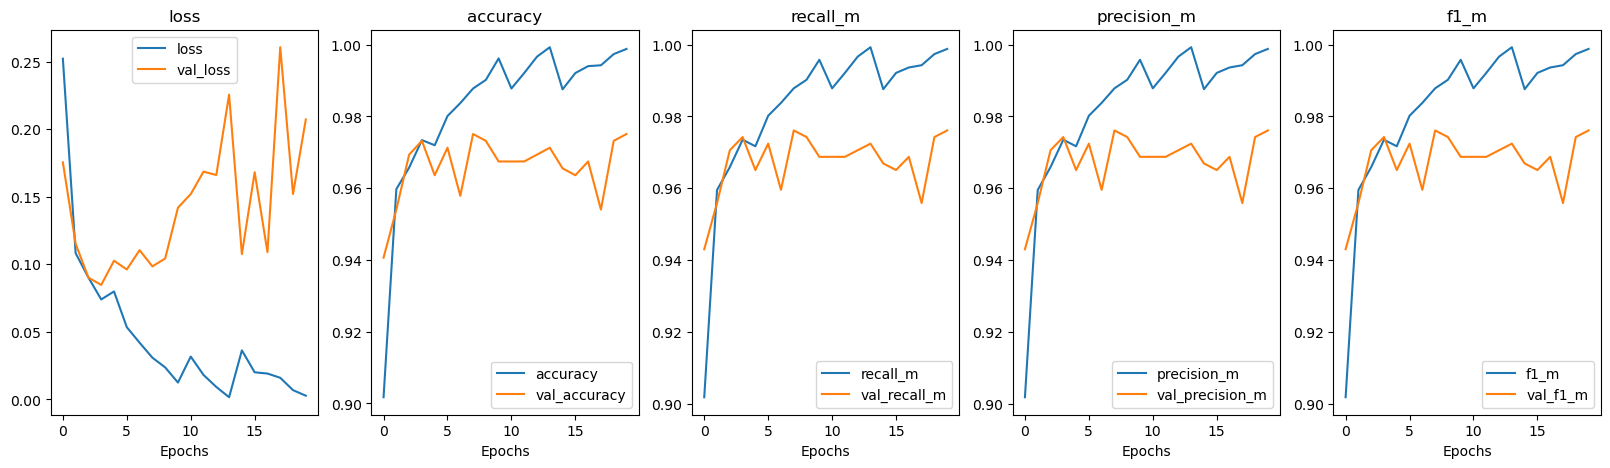

In [107]:
# 시각화
plt.figure(figsize=(20,5))
for i, key in enumerate(list(history.history.keys())[:5]):
    plt.subplot(1,5,i+1)
    plt.title(key)
    plt.plot(history.history[key]) 
    plt.plot(history.history['val_'+key])   
    plt.xlabel('Epochs')
    plt.legend([key, 'val_'+key])
plt.show()

### 예측

In [108]:
y_pred =  CNN_Adam.predict(x_test)

17/17 [==============================] - 0s 21ms/step


In [109]:
y_pred_argmax = np.argmax(np.array(y_pred), axis=1)
y_pred_argmax

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,

In [110]:
# 예측 결과 시각화
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test.argmax(-1),y_pred_argmax))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       128
           1       0.97      0.99      0.98       394

    accuracy                           0.97       522
   macro avg       0.97      0.95      0.96       522
weighted avg       0.97      0.97      0.97       522



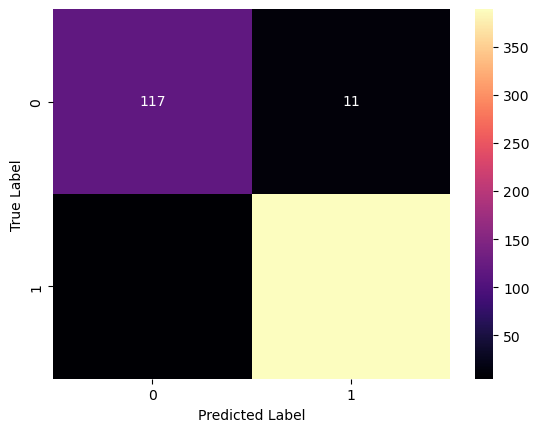

In [113]:
import seaborn as sns
heatmap = sns.heatmap(confusion_matrix(y_test.argmax(-1),y_pred_argmax), annot=True, fmt='.3g', 
                        xticklabels=['0','1'], yticklabels=['0','1'], cmap='magma')
heatmap.set_xlabel('Predicted Label')
heatmap.set_ylabel("True Label")
plt.show()

### Inference

In [114]:
# 9개의 이미지 랜덤추출
idx = np.random.randint(0,len(x_test),9)

In [124]:
idx

array([221, 474, 151,  77, 398, 502, 514, 106, 228])

In [115]:
import matplotlib.pyplot as plt
target_x, target_y = x_test[idx], y_test[idx]
predictions = CNN_Adam.predict(target_x)
predictions = predictions.argmax(axis=1)

1/1 [==============================] - 0s 32ms/step


In [125]:
predictions

array([0, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int64)

In [ ]:
label_name = {
    0: 'Normal',
    1: "Pneumonia"
}

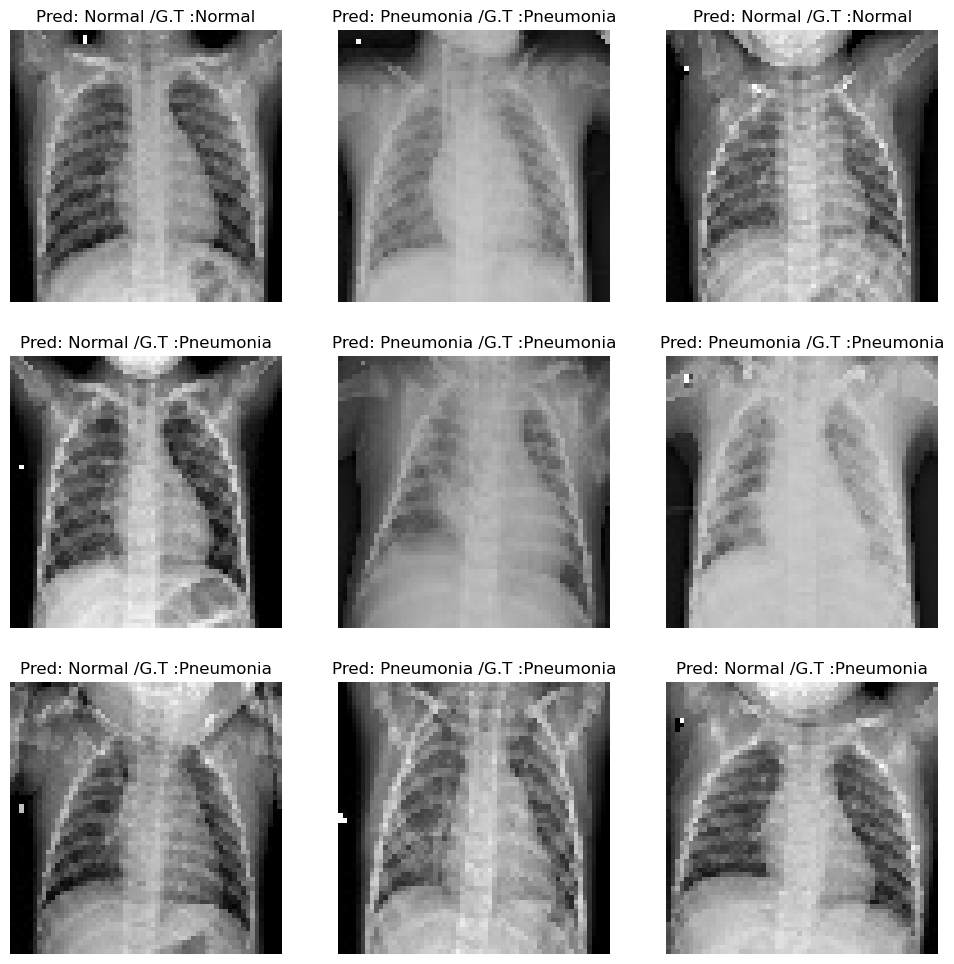

In [123]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred = label_name[predictions[i]]
    gth = label_name[y_test[i].argmax()]
    
    plt.title(f"Pred: {pred} /G.T :{gth}")
    plt.imshow(target_x[i])
    plt.axis('off')
    
plt.show()
    

### CNN with PyTorch